# Downstream adaption with MiniMol

This example shows how MiniMol can featurise small molecules that will then serve as an input to another model trained on a small downstream dataset from TDC ADMET. This allows to transfer the knowledge from the pre-trained MiniMol to another task. 

Before we start, let's make sure that the TDC package is installed in the environment. It takes a while, that's why we don't include it in the dependencies.

In [1]:
%pip install PyTDC

## Step 1: Getting the data
Next, we will build a predictor for the `HIA Hou` dataset, one of the binary classification benchmarks from TDC ADMET group. HIA stands for human intestinal absorption (HIA), which is related to the ability to absorb a substance through the gastrointestinal system into the bloodstream of the human body.

We then split the data based on molecular scaffolds into training, validation and test sets. 

In [2]:
from tdc.benchmark_group import admet_group

DATASET_NAME = 'HIA_Hou'

admet = admet_group(path="admet-data/")

mols_test = admet.get(DATASET_NAME)['test']
mols_train, mols_val = admet.get_train_valid_split(benchmark=DATASET_NAME, split_type='scaffold', seed=42)

Found local copy...
generating training, validation splits...
100%|██████████| 461/461 [00:00<00:00, 3408.78it/s]


In [3]:
print(f"Dataset - {DATASET_NAME}\n")
print(f"Val split ({len(mols_val)} mols): \n{mols_val.head()}\n")
print(f"Test split ({len(mols_test)} mols): \n{mols_test.head()}\n")
print(f"Train split ({len(mols_train)} mols): \n{mols_train.head()}\n")

Dataset - HIA_Hou

Val split (58 mols): 
                 Drug_ID                                               Drug  Y
0         Atracurium.mol  COc1ccc(C[C@H]2c3cc(OC)c(OC)cc3CC[N@@+]2(C)CCC...  0
1  Succinylsulfathiazole          O=C(O)CCC(=O)Nc1ccc(S(=O)(=O)Nc2nccs2)cc1  0
2            Ticarcillin  CC1(C)S[C@H]2[C@@H](NC(=O)[C@@H](C(=O)O)c3ccsc...  0
3          Raffinose.mol  OC[C@@H]1O[C@@H](OC[C@@H]2O[C@@H](O[C@]3(CO)O[...  0
4          Triamcinolone  C[C@@]12C=CC(=O)C=C1CC[C@@H]1[C@H]3C[C@@H](O)[...  1

Test split (117 mols): 
                Drug_ID                                               Drug  Y
0         Trazodone.mol         O=c1n(CCCN2CCN(c3cccc(Cl)c3)CC2)nc2ccccn12  1
1          Lisuride.mol  CCN(CC)C(=O)N[C@H]1C=C2c3cccc4[nH]cc(c34)C[C@@...  1
2  Methylergonovine.mol  CC[C@H](CO)NC(=O)[C@H]1C=C2c3cccc4[nH]cc(c34)C...  1
3      Methysergide.mol  CC[C@H](CO)NC(=O)[C@H]1C=C2c3cccc4c3c(cn4C)C[C...  1
4       Moclobemide.mol                       O=C(NCCN1CCOCC1)c1ccc(Cl

## Step 2: Generating molecular fingerprints
Now that we have the splits, we will use MiniMol to embed all molecules. The embedding will be added as an extra column in the dataframe returned by TDC.

In [4]:
from minimol import Minimol

featuriser = Minimol()

In [5]:
mols_val['Embedding'] = featuriser(list(mols_val['Drug']))
mols_test['Embedding'] = featuriser(list(mols_test['Drug']))
mols_train['Embedding'] = featuriser(list(mols_train['Drug']))

100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


The model is small, so it took us 6.6 seconds to generate the embeddings for almost 600 molecules. Here is a preview after the new column has been added:

In [6]:
print(mols_train.head())

           Drug_ID                                               Drug  Y  \
0        Guanadrel                      N=C(N)NC[C@@H]1COC2(CCCCC2)O1  1   
1      Cefmetazole  CO[C@@]1(NC(=O)CSCC#N)C(=O)N2C(C(=O)O)=C(CSc3n...  0   
2   Zonisamide.mol                           NS(=O)(=O)Cc1noc2ccccc12  1   
3   Furosemide.mol            NS(=O)(=O)c1cc(Cl)cc(NCc2ccco2)c1C(=O)O  1   
4  Telmisartan.mol  CCCc1nc2c(n1Cc1ccc(-c3ccccc3C(=O)O)cc1)=C[C@H]...  1   

                                           Embedding  
0  [0.0, 0.5511834, 0.8979431, 0.19619876, 0.7452...  
1  [0.0, 0.0, 0.7467004, 0.17419952, 0.11563285, ...  
2  [0.0, 1.0714495, 1.5657394, 0.0, 1.3655123, 0....  
3  [0.0, 0.0, 0.40348637, 0.0, 0.0, 0.8121755, 0....  
4  [0.08408047, 0.0, 0.0, 0.0, 0.0, 1.8257095, 0....  


## Step 3: Training a model
Now that the molecules are featurised leverging the representation MiniMol learned during its pre-training, we will set up a training and evaluation loop of a simple Multi-Layer Perceptron model using PyTorch.

Let's start by defining a new class for the dataset and then creating a separate dataloader for each split.

In [7]:
from torch.utils.data import DataLoader, Dataset
    
class AdmetDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples['Embedding'].tolist()
        self.targets = [float(target) for target in samples['Y'].tolist()]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = torch.tensor(self.samples[idx])
        target = torch.tensor(self.targets[idx])
        return sample, target

val_loader = DataLoader(AdmetDataset(mols_val), batch_size=128, shuffle=False)
test_loader = DataLoader(AdmetDataset(mols_test), batch_size=128, shuffle=False)
train_loader = DataLoader(AdmetDataset(mols_train), batch_size=32, shuffle=True)

Our model is a simple 3-layer perceptron with batch normalisation and dropout. We also add a residual connection that before the last layer concatates the the input features with the output from the second to last layer.

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class TaskHead(nn.Module):
    def __init__(self):
        super(TaskHead, self).__init__()
        self.dense1 = nn.Linear(512, 512)
        self.dense2 = nn.Linear(512, 512)
        self.dense3 = nn.Linear(512, 512)
        self.final_dense = nn.Linear(1024, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.10)

    def forward(self, x):
        original_x = x

        x = self.dense1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.dense2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.dense3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = torch.cat((x, original_x), dim=1)
        x = self.final_dense(x)
        
        return x

Below we declare the basic hyperparamters, optimiser, loss function and learning rate scheduler. We build a model factory that allows us to instatiate a fresh copy of everything, which will become useful later.

In [44]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

lr = 0.0003
epochs = 25
warmup = 5

loss_fn = nn.BCELoss()

def model_factory():
    model = TaskHead()
    optimiser = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
    lr_scheduler = CosineAnnealingLR(optimiser, T_max=epochs, eta_min=0)
    return model, optimiser, lr_scheduler

For evaluation we will use both AUROC and Average Precision metrics. The reported loss would be an average across all samples in the epoch.

In [45]:
import torch
from sklearn.metrics import roc_auc_score, average_precision_score

def evaluate(predictor, dataloader, loss_fn):
    predictor.eval()
    total_loss = 0
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            probs = F.sigmoid(predictor(inputs).squeeze())
            loss = loss_fn(probs, targets)
            total_loss += loss.item()
            all_probs.extend(probs.tolist())
            all_targets.extend(targets.tolist())

    loss = total_loss / len(all_probs)
    
    return (
        loss,
        roc_auc_score(all_targets, all_probs),
        average_precision_score(all_targets, all_probs)
    )

Training is a rather standard boilerplate loop: 

In [46]:
def train_one_epoch(predictor, train_loader, optimiser, lr_scheduler, loss_fn, epoch, verbose=True):
    predictor.train()        
    train_loss = 0
    
    lr_scheduler.step(epoch)
    for i, (inputs, targets) in enumerate(train_loader):
        optimiser.zero_grad()
        probs = torch.sigmoid(predictor(inputs).squeeze())
        loss = loss_fn(probs, targets)
        loss.backward()
        optimiser.step()
        train_loss += loss.item()

    train_loss /= (len(train_loader) * 32)

    val_loss, auroc, avpr = evaluate(predictor, val_loader, loss_fn)

    if verbose:
        print(
            f"## Epoch {epoch+1}\t"
            f"train_loss: {train_loss:.4f}\t"
            f"val_loss: {val_loss:.4f}\t"
            f"val_auroc: {auroc:.4f}\t"
            f"val_avpr: {avpr:.4f}"
        )
    return predictor

And now, let's see how good our model gets after training... 🚀

In [47]:
model, optimiser, lr_scheduler = model_factory()

val_loss, val_auroc, val_avpr = evaluate(model, val_loader, loss_fn)
print(
    f"## Epoch 0\t"
    f"train_loss: ------\t"
    f"val_loss: {val_loss:.4f}\t"
    f"val_auroc: {val_auroc:.4f}\t"
    f"val_avpr: {val_avpr:.4f}"
)

for epoch in range(epochs):
    model = train_one_epoch(model, train_loader, optimiser, lr_scheduler, loss_fn, epoch)

test_loss, test_auroc, test_avpr = evaluate(model, test_loader, loss_fn)
print(
    f"test_loss: {test_loss:.4f}\n"
    f"test_auroc: {test_auroc:.4f}\n"
    f"test_avpr: {test_avpr:.4f}"
)

## Epoch 0	train_loss: ------	val_loss: 0.0116	val_auroc: 0.4110	val_avpr: 0.8551
## Epoch 1	train_loss: 0.0228	val_loss: 0.0090	val_auroc: 0.5313	val_avpr: 0.9012
## Epoch 2	train_loss: 0.0119	val_loss: 0.0062	val_auroc: 0.7820	val_avpr: 0.9634
## Epoch 3	train_loss: 0.0075	val_loss: 0.0044	val_auroc: 0.8722	val_avpr: 0.9822
## Epoch 4	train_loss: 0.0049	val_loss: 0.0037	val_auroc: 0.8571	val_avpr: 0.9784
## Epoch 5	train_loss: 0.0038	val_loss: 0.0035	val_auroc: 0.7970	val_avpr: 0.9670
## Epoch 6	train_loss: 0.0027	val_loss: 0.0034	val_auroc: 0.8546	val_avpr: 0.9769
## Epoch 7	train_loss: 0.0024	val_loss: 0.0032	val_auroc: 0.8571	val_avpr: 0.9773
## Epoch 8	train_loss: 0.0020	val_loss: 0.0034	val_auroc: 0.8271	val_avpr: 0.9732
## Epoch 9	train_loss: 0.0014	val_loss: 0.0032	val_auroc: 0.8521	val_avpr: 0.9775
## Epoch 10	train_loss: 0.0015	val_loss: 0.0032	val_auroc: 0.8672	val_avpr: 0.9794
## Epoch 11	train_loss: 0.0014	val_loss: 0.0033	val_auroc: 0.8496	val_avpr: 0.9759
## Epoch 12	tr

The model trained in just 1.4s, reaching AUROC on the test set of 0.9683. Pretty good!

## Step 4: Improvements

The result can be further improved. One problem is that the accuracy is quite sensitive to both the train-val splitting (reminder - we use scaffold splitting strategy) and the weight initialisation. Let's visualise the distribution by training a few models:

In [48]:
def dataloader_factory(seed):
    mols_train, mols_val = admet.get_train_valid_split(benchmark=DATASET_NAME, split_type='scaffold', seed=seed)

    mols_val['Embedding'] = featuriser(list(mols_val['Drug']))
    mols_train['Embedding'] = featuriser(list(mols_train['Drug']))

    val_loader = DataLoader(AdmetDataset(mols_val), batch_size=128, shuffle=False)
    train_loader = DataLoader(AdmetDataset(mols_train), batch_size=32, shuffle=True)

    return val_loader, train_loader

generating training, validation splits...
100%|██████████| 5/5 [00:00<00:00,  6.19it/s]


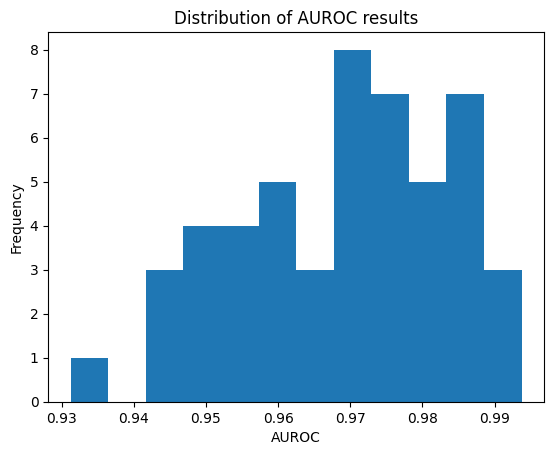

In [53]:
import matplotlib.pyplot as plt

results = []
repeats = 50
val_loader, train_loader = dataloader_factory(42)

for _ in range(repeats):
    model, optimiser, lr_scheduler = model_factory()
    for epoch in range(epochs):
        model = train_one_epoch(model, train_loader, optimiser, lr_scheduler, loss_fn, epoch, verbose=False)
    _, auroc, _ = evaluate(model, val_loader, loss_fn)
    results.append(auroc)

plt.hist(results, bins=12)
plt.xlabel('AUROC')
plt.ylabel('Frequency')
plt.title('Distribution of AUROC results')
plt.show()

To mitigate the problem, we adapt two techniques:

- Ensembling models trained on different folds of train-val data. Since the training is so fast, fitting a few addtional models is not a big deal. The train-val splitting method is provided by TDC.

- Rather than choosing the model at the last epoch, we will use best validation loss to decide which one to choose.

Below we implement a method that create a new training and validation dataloader for each fold, and also a method for ensemble-based evaluationm, where probabiltiies for each predition are averaged across all models in the ensemble.

In [50]:
def evaluate_ensemble(predictors, dataloader, loss_fn):
    total_loss = 0
    all_probs = []
    all_targets = []

    with torch.no_grad():
        
        for inputs, targets in dataloader:
            model_outputs = [predictor(inputs).squeeze() for predictor in predictors]
            averaged_output = torch.sigmoid(torch.mean(torch.stack(model_outputs), dim=0))

            loss = loss_fn(averaged_output, targets)
            total_loss += loss.item()

            all_probs.extend(averaged_output.tolist())
            all_targets.extend(targets.tolist())

    loss = total_loss / len(all_probs)
    return loss, roc_auc_score(all_targets, all_probs), average_precision_score(all_targets, all_probs)

Finally, let's see how much better our model gets!

In [52]:
from copy import deepcopy

seeds = [1, 2, 3, 4, 5]

best_models = []

for seed in seeds:
    val_loader, train_loader = dataloader_factory(seed)
    model, optimiser, lr_scheduler = model_factory()

    best_epoch = {"model": None, "result": None}
    for epoch in range(epochs):
        model = train_one_epoch(model, train_loader, optimiser, lr_scheduler, loss_fn, epoch)
        val_loss, val_auroc, _ = evaluate(model, val_loader, loss_fn)

        if best_epoch['model'] is None:
            best_epoch['model'] = deepcopy(model)
            best_epoch['result'] = val_loss
        else:
            best_epoch['model'] = best_epoch['model'] if best_epoch['result'] <= val_loss else deepcopy(model)
            best_epoch['result'] = best_epoch['result'] if best_epoch['result'] <= val_loss else val_loss 

    best_models.append(best_epoch['model'])

test_loss, test_auroc, test_avpr = evaluate_ensemble(best_models, test_loader, loss_fn)
print(
    f"test_loss: {test_loss:.4f}\n"
    f"test_auroc: {test_auroc:.4f}\n"
    f"test_avpr: {test_avpr:.4f}"
)

generating training, validation splits...
100%|██████████| 5/5 [00:00<00:00,  6.72it/s]


## Epoch 1	train_loss: 0.0137	val_loss: 0.0083	val_auroc: 0.6162	val_avpr: 0.9296
## Epoch 2	train_loss: 0.0078	val_loss: 0.0056	val_auroc: 0.8796	val_avpr: 0.9819
## Epoch 3	train_loss: 0.0052	val_loss: 0.0040	val_auroc: 0.9300	val_avpr: 0.9900
## Epoch 4	train_loss: 0.0037	val_loss: 0.0034	val_auroc: 0.9552	val_avpr: 0.9938
## Epoch 5	train_loss: 0.0028	val_loss: 0.0031	val_auroc: 0.9636	val_avpr: 0.9951
## Epoch 6	train_loss: 0.0022	val_loss: 0.0028	val_auroc: 0.9692	val_avpr: 0.9959
## Epoch 7	train_loss: 0.0014	val_loss: 0.0028	val_auroc: 0.9720	val_avpr: 0.9963
## Epoch 8	train_loss: 0.0015	val_loss: 0.0028	val_auroc: 0.9748	val_avpr: 0.9967
## Epoch 9	train_loss: 0.0012	val_loss: 0.0029	val_auroc: 0.9664	val_avpr: 0.9955
## Epoch 10	train_loss: 0.0009	val_loss: 0.0028	val_auroc: 0.9692	val_avpr: 0.9958
## Epoch 11	train_loss: 0.0009	val_loss: 0.0026	val_auroc: 0.9748	val_avpr: 0.9966
## Epoch 12	train_loss: 0.0007	val_loss: 0.0026	val_auroc: 0.9748	val_avpr: 0.9966
## Epoch 13	t

generating training, validation splits...


## Epoch 24	train_loss: 0.0006	val_loss: 0.0025	val_auroc: 0.9748	val_avpr: 0.9966
## Epoch 25	train_loss: 0.0004	val_loss: 0.0025	val_auroc: 0.9748	val_avpr: 0.9966


100%|██████████| 5/5 [00:00<00:00,  7.42it/s]


## Epoch 1	train_loss: 0.0165	val_loss: 0.0085	val_auroc: 0.8528	val_avpr: 0.9818
## Epoch 2	train_loss: 0.0089	val_loss: 0.0055	val_auroc: 0.9736	val_avpr: 0.9975
## Epoch 3	train_loss: 0.0057	val_loss: 0.0037	val_auroc: 0.9698	val_avpr: 0.9971
## Epoch 4	train_loss: 0.0041	val_loss: 0.0029	val_auroc: 0.9736	val_avpr: 0.9975
## Epoch 5	train_loss: 0.0031	val_loss: 0.0024	val_auroc: 0.9849	val_avpr: 0.9986
## Epoch 6	train_loss: 0.0023	val_loss: 0.0022	val_auroc: 0.9849	val_avpr: 0.9986
## Epoch 7	train_loss: 0.0019	val_loss: 0.0020	val_auroc: 0.9925	val_avpr: 0.9993
## Epoch 8	train_loss: 0.0015	val_loss: 0.0020	val_auroc: 0.9887	val_avpr: 0.9990
## Epoch 9	train_loss: 0.0016	val_loss: 0.0018	val_auroc: 0.9925	val_avpr: 0.9993
## Epoch 10	train_loss: 0.0010	val_loss: 0.0019	val_auroc: 0.9925	val_avpr: 0.9993
## Epoch 11	train_loss: 0.0011	val_loss: 0.0018	val_auroc: 0.9887	val_avpr: 0.9989
## Epoch 12	train_loss: 0.0009	val_loss: 0.0019	val_auroc: 0.9925	val_avpr: 0.9993
## Epoch 13	t

generating training, validation splits...


## Epoch 24	train_loss: 0.0006	val_loss: 0.0017	val_auroc: 0.9925	val_avpr: 0.9993
## Epoch 25	train_loss: 0.0005	val_loss: 0.0016	val_auroc: 0.9925	val_avpr: 0.9993


100%|██████████| 5/5 [00:00<00:00,  6.74it/s]


## Epoch 1	train_loss: 0.0171	val_loss: 0.0085	val_auroc: 0.7051	val_avpr: 0.9304
## Epoch 2	train_loss: 0.0088	val_loss: 0.0058	val_auroc: 0.8590	val_avpr: 0.9800
## Epoch 3	train_loss: 0.0059	val_loss: 0.0042	val_auroc: 0.9103	val_avpr: 0.9887
## Epoch 4	train_loss: 0.0041	val_loss: 0.0035	val_auroc: 0.9103	val_avpr: 0.9886
## Epoch 5	train_loss: 0.0029	val_loss: 0.0034	val_auroc: 0.8910	val_avpr: 0.9832
## Epoch 6	train_loss: 0.0025	val_loss: 0.0032	val_auroc: 0.9231	val_avpr: 0.9898
## Epoch 7	train_loss: 0.0018	val_loss: 0.0032	val_auroc: 0.8814	val_avpr: 0.9802
## Epoch 8	train_loss: 0.0015	val_loss: 0.0031	val_auroc: 0.8718	val_avpr: 0.9755
## Epoch 9	train_loss: 0.0013	val_loss: 0.0031	val_auroc: 0.8878	val_avpr: 0.9809
## Epoch 10	train_loss: 0.0011	val_loss: 0.0027	val_auroc: 0.8910	val_avpr: 0.9818
## Epoch 11	train_loss: 0.0009	val_loss: 0.0028	val_auroc: 0.8910	val_avpr: 0.9818
## Epoch 12	train_loss: 0.0009	val_loss: 0.0029	val_auroc: 0.8942	val_avpr: 0.9827
## Epoch 13	t

generating training, validation splits...


## Epoch 24	train_loss: 0.0005	val_loss: 0.0030	val_auroc: 0.8814	val_avpr: 0.9796
## Epoch 25	train_loss: 0.0005	val_loss: 0.0030	val_auroc: 0.8814	val_avpr: 0.9796


100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


## Epoch 1	train_loss: 0.0215	val_loss: 0.0112	val_auroc: 0.5370	val_avpr: 0.9444
## Epoch 2	train_loss: 0.0115	val_loss: 0.0070	val_auroc: 0.7870	val_avpr: 0.9688
## Epoch 3	train_loss: 0.0069	val_loss: 0.0045	val_auroc: 0.8380	val_avpr: 0.9821
## Epoch 4	train_loss: 0.0048	val_loss: 0.0033	val_auroc: 0.8472	val_avpr: 0.9838
## Epoch 5	train_loss: 0.0038	val_loss: 0.0031	val_auroc: 0.8241	val_avpr: 0.9793
## Epoch 6	train_loss: 0.0029	val_loss: 0.0028	val_auroc: 0.8287	val_avpr: 0.9803
## Epoch 7	train_loss: 0.0022	val_loss: 0.0027	val_auroc: 0.8241	val_avpr: 0.9800
## Epoch 8	train_loss: 0.0016	val_loss: 0.0028	val_auroc: 0.8380	val_avpr: 0.9821
## Epoch 9	train_loss: 0.0016	val_loss: 0.0027	val_auroc: 0.8241	val_avpr: 0.9793
## Epoch 10	train_loss: 0.0015	val_loss: 0.0026	val_auroc: 0.8380	val_avpr: 0.9826
## Epoch 11	train_loss: 0.0011	val_loss: 0.0026	val_auroc: 0.8472	val_avpr: 0.9842
## Epoch 12	train_loss: 0.0011	val_loss: 0.0027	val_auroc: 0.8519	val_avpr: 0.9849
## Epoch 13	t

generating training, validation splits...


## Epoch 24	train_loss: 0.0006	val_loss: 0.0025	val_auroc: 0.8333	val_avpr: 0.9818
## Epoch 25	train_loss: 0.0006	val_loss: 0.0025	val_auroc: 0.8333	val_avpr: 0.9818


100%|██████████| 1/1 [00:00<00:00, 10.94it/s]
featurizing_smiles, batch=13: 31it [00:00, 123.61it/s]                        
100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


## Epoch 1	train_loss: 0.0150	val_loss: 0.0079	val_auroc: 0.5238	val_avpr: 0.8859
## Epoch 2	train_loss: 0.0080	val_loss: 0.0054	val_auroc: 0.7343	val_avpr: 0.9434
## Epoch 3	train_loss: 0.0054	val_loss: 0.0040	val_auroc: 0.8045	val_avpr: 0.9655
## Epoch 4	train_loss: 0.0039	val_loss: 0.0036	val_auroc: 0.8195	val_avpr: 0.9686
## Epoch 5	train_loss: 0.0027	val_loss: 0.0035	val_auroc: 0.8271	val_avpr: 0.9716
## Epoch 6	train_loss: 0.0019	val_loss: 0.0035	val_auroc: 0.8170	val_avpr: 0.9691
## Epoch 7	train_loss: 0.0018	val_loss: 0.0033	val_auroc: 0.8396	val_avpr: 0.9745
## Epoch 8	train_loss: 0.0014	val_loss: 0.0034	val_auroc: 0.8471	val_avpr: 0.9769
## Epoch 9	train_loss: 0.0010	val_loss: 0.0035	val_auroc: 0.8521	val_avpr: 0.9775
## Epoch 10	train_loss: 0.0009	val_loss: 0.0036	val_auroc: 0.8396	val_avpr: 0.9750
## Epoch 11	train_loss: 0.0008	val_loss: 0.0036	val_auroc: 0.8471	val_avpr: 0.9763
## Epoch 12	train_loss: 0.0006	val_loss: 0.0036	val_auroc: 0.8521	val_avpr: 0.9774
## Epoch 13	t

As we can see, in less than 15s the ensemble was trained and reached performance of 0.9844 in AUROC on the test set. That's a decent improvement coming from 0.9683 that we got for a single model. More importantly, the ensemble is not senstitive to which part of the data is used for validation (because we train n models on n folds), and is less sensitive to the intialisation because we intialise n models getting somewhere close to an average performance. 

The results could be further improved by sweeping hyperparameters. Considering the low cost of fitting these tiny models, it would still be very fast. The results reported in the paper are slighly better than what we show here, thanks to sweeping that we performed for each task.  